In [1]:
from utils import set_pyplot_params
set_pyplot_params()

# Stima dei conteggi

Nel capitolo precedente abbiamo risolto il problema che implicano la stima delle proporzioni.
Nel problema dell'Euro abbiamo stimato la probabilità che una moneta cada di testa e nell'esercizio abbiamo stimato la media delle battute, la frazione delle persone che imbrogliano sulle tasse.

Chiaramente alcuni di questi problemi sono più realistici di altri.
In questo capitolo lavoreremo sul problema del del conteggio o della stima delle dimensione della popolazione.
Ancora alcuni esempi esempi sembreranno sciocchi, ma alcuni di essi con il problema dei Carri armati tedeschi ha avuto applicazioni reali spesso in situazioni di vita o di morte.

## Il problema dei treni

Il problema dei treni è trattato nel libro di Frederick Mosteller [*Fifty Challenging Problems in Probability with Solutions*](https://store.doverpublications.com/0486653552.html).

> "Una ferrovia numera le sua locomotive in ordine da 1..N. Un giorno vediamo una locomotiva con il numero 60. Stima quante locomotive ha la ferrovia."

Basandosi sulla osservazione sappiamo che la stessa ha 60 o più locomotive. Ma quante di più? Applichiamo il ragionamento  Bayesiano possiamo rompere il problema in due passi:

* Cosa sapevamo di $N$ prima di vedere il dato?
* Per ogni valore dato di $N$, quale è la verosmiglianza di vedere il dato?


Per rispondere alla prima domanda si usa la distribuzione a priori, per la seconda si usa la verosomiglianza.
Non abbiamo molte basi per scegliere la distribuzione a priori, dunque partiremo con qualcosa di semplice e consideremo alternative.

Assumiamo che $N$ sia egualmente distribuita tra 1 e 1000.

Qui la distribuzione a priori:

In [2]:
import numpy as np
from distribution import Pmf

hypos = np.arange(1, 1001)
prior = Pmf(1, hypos)

Ora immaginiamo la verosomiglianza dei dati.
In una ipotetica flotta di $N$ locomotive, quale è la probabilità di vedere il numero 60?
Se assumiamo che abbiamo la stessa probabilità di vedere ogni locomotiva, la possibiltà di vedere una in particolare è $1/N$.
Qui la funzione che esegue l'aggiornamento:

In [3]:
def update_train(pmf, data):
    """Update pmf based on new data."""
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

Questa funzione risulta familiare, è la stessa funzione di aggiornamento del problema dei dadi nel capitolo precedente.
In termini di verosomiglianza il problema dei treni è lo stesso del problema dei dadi.
Qui l'aggiornamento:

In [4]:
data = 60
posterior = prior.copy()
update_train(posterior, data)

Ed ecco come si presenta la distribuzione a posteriori:

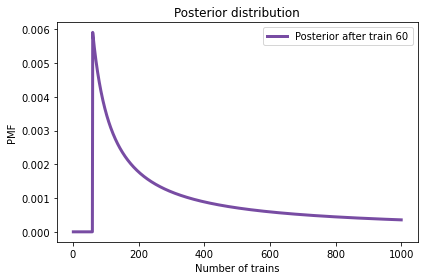

In [5]:
from utils import decorate

posterior.plot(label='Posterior after train 60', color='C4')
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distribution')

Non sorprende che il massimo valore sia 60 e che i valori sotto di esso siano 0.

In [6]:
posterior.max_prob()

60

Questa non sembra un gran che come come ipotesi, quale è la possibilità che tu abbia visto il treno con il numero più alto?
Dopotutto, se vuoi massimizzare la possibilità di ottenere la risposta esatta potresti dire 60.
Questo potrebbe non essere il nostro obiettivo.
Una alternativa è quella di calcolare la media della distribuzione a posteriori.
Dato un insieme di possibili quantità $q_i$ e delle loro probabilità $p_i$ la media delle distribuzioni sarà
$$\mathrm{mean} = \sum_i p_i q_i$$
Possiamo calcolarla come:

In [7]:
np.sum(posterior.ps * posterior.qs)

333.41989326370776

oppure con il comando 

In [8]:
posterior.mean()

333.41989326370776

## Sensibilita della distribuzione a priori

La distribuzione che ho usati nella distibuzione precedente è uniforme tra 1 e 1000, ma non abbiamo dato nessuna giustificazione sulla scelta della distribuzione o di quel particolare limite superiore.

Ci si potrebbe chiedere se la distribuzione a posteriori sia sensibile alla distribuzione a priori.
Con pochi dati "nel nostro caso una solo osservazione" è quello che succede.
La tabella mostra cosa succcede al variare del limite superiore:

In [9]:
import pandas as pd

df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

for high in [100, 500, 700, 1000, 2000, 5000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    update_train(pmf, data=60)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
100,78.218336
500,207.079228
700,259.955529
1000,333.419893
2000,552.179017
5000,1115.021395


Al variare il limite superiore, la media a postesiori cambia sostanzialmente. 
Questo è male.
Quando la distribuzione a posteriori e sensibile alla priori ci sono due strade in cui procedere:

* Ottenere più dati
* Ottenere più informazioni al fine di scegliere una distribuzione a priori migliore.

Con più dati la distribuzione a posteriori basate su differenti distribuzioni a priori tendono a convergere.
Per esempio supponiamo di vedere oltre al treno numero 60 il treno 30 e il 90.
Vediamo come la media della distribuzione a posteriori cambia al variare del limite superiore dopo aver osservato tre treni: 

In [10]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for high in [100, 500, 700, 1000, 2000, 5000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    for data in dataset:
        update_train(pmf, data)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
100,94.684234
500,151.849588
700,158.724031
1000,164.305586
2000,171.338181
5000,175.856181


Le differenze sono minori, ma apparentemente tre treni non sono abbastanza per far convergere la distribuzione a posteriori.

## Legge della potenza della distribuzione a priori

Se più dati non sono disponibili, un'altra opzione è quella di migliorare la distribuzione a priori cercando piu informazioni 
E' probabilmente non ragionevole assumere che una compagnia con 1000 treni abbia la stessa probabilità di una compagnia con un solo treno.

Con un pò di lavoro potremo trovare un elenco di aziende del settore, oppure potremmo intervistare un esperto di dominio e raccogliere le informazioni che ci servono.

Ma anche senza entrare nel dettaglio economico delle ferrovie, potremmo fare delle ipotesi plausibili.
In molti campi, ci sono molte aziende piccole, qualche azienda media e al massimo una o due grandi aziende.

Nei fatti la distribuzione delle compagnie tende a seguire la legge della potenza come scrive Robert Axtell su [*Science*](<http://www.sciencemag.org/content/293/5536/1818.full.pdf>).

Questa legge ci suggerische che se abbiamo 1000 compagnie con meno di 10 locomotivem potrebbe essere che avremo 100 compagnie con 100 locomotive e 10 compagnie con 100 e possibilmente 1 compagnia con 10'000 locomotive.

Matematicamente, la legge della potenza significa che il numero delle compagnie con una certa dimensione, $N$ è proporzionale a 
$(1/N)^{\alpha}$ dove $\alpha$ è un parametreo che spesso si avvicina a 1.

Possiamo costruire la distribuzione a priori basata sulla legge della potenza in questo modo.

In [11]:
alpha = 1.0
ps = hypos**(-alpha)
power = Pmf(ps, hypos, name='power law')
power.normalize()

9.094508852984436

andiamo a compararla con la distribuzione uniforme.

In [12]:
hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

1000

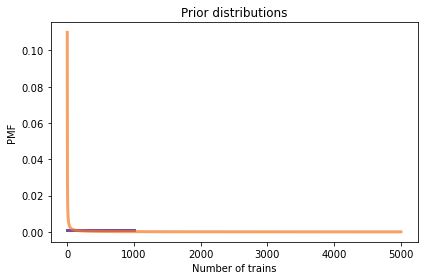

In [13]:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Prior distributions')

In [14]:
dataset = [60]
update_train(uniform, dataset)
update_train(power, dataset)

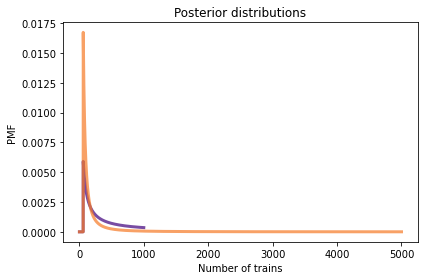

In [15]:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distributions')

In [16]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for high in [100, 500, 700, 1000, 2000, 5000]:
    hypos = np.arange(1, high+1)
    ps = hypos**(-alpha)
    power = Pmf(ps, hypos)
    for data in dataset:
        update_train(power, data)
    df.loc[high] = power.mean()
    
df

,Posterior mean
Upper bound,
100,94.579460
500,130.708470
700,132.338572
1000,133.275231
2000,133.997463
5000,134.211950


Ora le differenze sono diminuite. Nei fatti con un limite molto grande la media converge verso il valore di 134.
La legge della potenza è molto realistica, perchè è basata sulle informazioni generali circa la dimensione delle compagnie e si comporta anche meglio nella pratica.

## Intervallo di credibilità

Abbiamo appena visto due modi per riassumere la distribuzione a posteriori: il valore con la priorità più alta e la media della distribuzione a posteriori.
Questo sono entrambre **punti di stima**, singoli valori che stimano la quantità a cui siamo interessati.

Un'altro modo per riassumente la distribuzione a posteriori è tramite i percentili.
Se hai eseguito un test standardizzato, dovresti essere familiare con i percentili.
Per esempio, se il tuo punteggio è nel 90° percentile, significa che hai fatto bene o meglio del 90% delle persone che hanno fatto i test.

Se ci viene dato un valore, `x`, possiamo calcolare il **rango percentile** cercando tutti i valori minori o uguali a `x` e sommando le loro probabilità.

L'oggetto `Pmf` ci da una funzione che esegue questo calcolo.
Per esempio possiamo calcolare la probabilità che la compagnia 100 o meno treni:

In [17]:
power.le_dist(100)

0.29372230050690157

Con la legge della potenza e un dataset di tre treni il risultato di circa il 29%.
Dunque 100 treni sono al 29° percentile.
Giriamo il problema supponiamo di voler calcolare un particolare percentile, per esempio, la mediana della distribuzione è il 50° percentile.
Possiamo calcolare tale valore aggiungendo probabilità finchè il totale non eccede 0.5.
Questa è la funzione che esegue questo compito:

In [18]:
def quantile(pmf, prob):
    """Compute a quantile with the given prob."""
    total = 0
    for q, p in pmf.items():
        total += p
        if total >= prob:
            return q
    return np.nan

Il ciclo usa `items`, e itera le quantità e le probabilità della distribuzione.
Dentro il ciclo aggiungiamo le probabilità delle quantità ordinate.
Quando il totale eguaglia o eccede `prob`, ritorniamo la corrispondente quantità.
Questa funzione è chiamata `quantile` perchè calcola un quantile piuttosto che un percentile.  
La differenza è come si specifica `prob`.

Se `prob` è una percentuale tra 0 e 100 chiamiamo la corrispondente quantità percentile.
Se `prob` è una probabilità tra 0 e 1, chiamiamo la corrispondente quantità **quantile**.

Qui come possiamo usare la funzione per calcolare il 50° percentile della distribuzione a posteriori:

In [19]:
quantile(power, 0.5)

113

Il risultato, 113 treni rappresenta la mediana della distribuzione a posteriori.
`Pmf` ci da a disposizione un metodo chiamato `quantile` che fa la stessa cosa.
Possiamo chiamarlo per calcolare il 5° e il 95° percentile:

In [20]:
power.quantile([0.05, 0.95])

array([ 91., 243.])

Il risultato è un intervallo di valori tra 91 e 243 che implica:

* che il numero dei treni sia minore di 51 ha una probabilità del 5%
* che il numero dei treni sia maggiore di 243 ha una probabilità del 5%

Perciò la probabilità che il numero dei treni sia compreso tra 91 e 243 è del 90% (escludendo il valore 91 e includendo il valore 243).

Per questa ragione questo intervallo è chiamato **intervallo di credibilità**.
`Pmf` ci fornisce la funzione `credible_interval` che calcola un intervallo che contiene la probabilità data.

In [21]:
power.credible_interval(0.9)

array([ 91., 243.])

## Il problema dei carri armati tedeschi

Durante la seconda guerra mondiale, la divisione economica di guerra della ambasciata americana a Londra usò l'analisi statistica per stimare la produzione tedesca di carri armati e altri equipaggiamenti.

Gli alleati catturarono diari, inventari e record di riparazione che inclusero numeri seriali di telai motori di ogni carro armato.

Le analisi di questi record indicarono che i numeri seriali erano allocati dai produttori e del tipo di carro a blocchi di 100 numeri, questi numeri in ogni blocco furono usati sequenzialmente. Dunque il problema della stima dei carri Tedeschi può essere ridotto, all'interno di ogni blocco di 100 numeri ad una variante del problema dei treni.

Basandosi su queste su queste intuizioni, gli analisti Americani e i Britannici produssero stime sostanzialmente più basse di altre basate su altre forme di intelligence.

E dopo la guerra la stima di revelò molto accurata.

Se fecero analisi simili per gomme, camion, missili e altri equipaggiamenti, fornendo stime accurate.
Il problema dei carri tedeschi è un problema storico interessante è anche un esempio reale carino di una stima statistica e applicata al mondo reale.

Per saperne di più sul problema qui un articolo su [wikipedia](https://en.wikipedia.org/wiki/German_tank_problem)

## Distribuzione di probabilità a priori

Tra i Bayesiani, ci sono due approcci per scegliere la distribuzione a priori.
Alcuni raccomandano di scegliere la distribuzione che meglio rappresenta le informazioni 
di background circa il problema in tal caso la distribuzione si dice **informativa**.

Il problema di usare una distribuzione informativa e che alcune persone potrebbero avere informazioni indipendenti o interpretare le informazioni differentemente. 

Quindi le distribuzioni a priori potrebbero sembrare arbitrarie.

L'altrernative è chiamata **distribuzione a priori non informativa** che è la meno ristretta possibile, per far parlare i dati da soli. In alcuni casi si può identificare una distribuzione a priori che ha questa proprietà, così da rappresentare le informazioni minimali circa le proprietà stimate.

Le distribuzioni non informative sono interessanti perchè sembrano più obiettive.
Sono generalmente a favore nell'usare le distribuzioni informative.
Perchè?

Primo, le analisi Bayesiane sono sempre basate su modellazioni decisionali.
Scegliere la distribuzione a priori corretta è una di queste decisoni ma non la sola e potrebbe non essere la più soggettiva.
Dunque se una distribuzione non informativa è più oggettiva, l'intera analisi resterà soggettiva.

Ancora per molti problemi pratici è molto probabilte che ti troverai in una di queste due situazioni.
O si hanno molti dati o non si hanno molti dati.

Se si hanno molti dati la distribuzione a priori non interessa molto, le distribuzioni informative e non informative daranno gli stessi risultati.
Se non si hanno molti dati, usare tutte le informazioni di background (tipo la legge della potenza) può fare grandi differenze.

E se, come nel caso dei carri armati Tedeschi dobbiamo prendere decisioni che portano alla vita o alla morte. 
Probabilmente userai tutte le informazioni in tuo possesso, piuttosto che mantenere una illusione di oggettività pretendendo di sapere meno di quello che sai.

## Riassunto

In questo capitolo abbiamo introdotto il problema dei treni, che risulta avere la stessa funzione di verosomiglianza del problema dei dadi e che può essere applicato al problema dei carri armati tedeschi.

In tutti questo esempi, l'obiettivo è quello di stimare un conteggio o quello di stimare una popolazione.
Nel prossimo capitolo parleremo di "quote" come alternativa alle probabilità e la regola di Bayes come forma alternativa del teorema di Bayes.

Calcoleremo distribuzioni di somme e di prodotti e useremo questo per stimare il numero dei membri del Congresso che sono corrotti, tra gli altri problemi. 

**Esercizio:** Supponiamo che tu stia tenendo un discorso in una grande sala conferenze è un capo dei vigili del fuoco ci interrompa perchè secondo lui le persone nella stanza superino il limite massimo di 1200 persone.
Noi pensiamo invece che le persone di essere meno di 1200 persone, ci offriamo di dimostrarlo.

Ci metteremmo troppo a contare e perciò proviamo un esperimento:
* Domandiamo quante persone sono nate l'11 maggio e due persone alzano la mano. 
* Domandiamo quante persone sono nate il 23 maggio  e una persona alza la mano.
* Domandiamo quante persone sono nate il 01 agosto e nessuno alza la mano. 

Quante persono sono nella stanza? 
Quale è la probabilità che nella stanza ci siano più di 1200 persone.
Suggerimento ricorda la distribuzione binomiale.

In [22]:
# creaiamo una distribuzione uniforme da 1 a 2500

max_audience = 2000

hypos = np.arange(1, max_audience, 10)
prior = Pmf(1, hypos)
prior.normalize()


200

In [23]:
# Soluzione

# Possiamo usare la distribuzione binomiale per calcolare la probabilità
# dei dati per ogni ipotetica dimensione della audience

from scipy.stats import binom

likelihood1 = binom.pmf(2, hypos, 1/365)
likelihood2 = binom.pmf(1, hypos, 1/365)
likelihood3 = binom.pmf(0, hypos, 1/365)

In [24]:
# eseguiamo l'aggiornamento e normalizziamo il risultato

posterior = prior * likelihood1 * likelihood2 * likelihood3
posterior.normalize()

0.006758799800451577

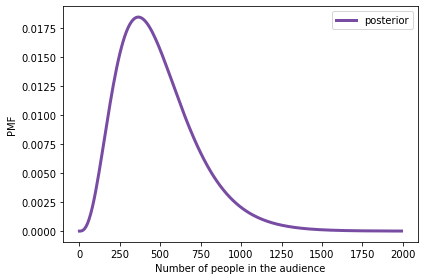

In [25]:
# Visualizziamo la distribuzione dell'odiences

posterior.plot(color='C4', label='posterior')
decorate(xlabel='Number of people in the audience',
         ylabel='PMF')

In [26]:
posterior.max_prob()

361

In [27]:
posterior.mean()

486.22551616872977

In [28]:
posterior.credible_interval(0.9)

array([171., 941.])

In [29]:
posterior.gt_dist(1200)

0.011543092507705329

**Esercizio:** Vedo spesso dei conigli nel giardino dietro a casa mia, ma non è facile isolarli, di conseguenza non puoi conoscere quanti ce ne siano.

Supponiamo di sviluppare una fototrappola che fotografa il primo coniglio che vede ogni giorno. Dopo tre giorni comapriamo le fotografie e concludiamo che due di esse sono lo stesso coniglio e gli altri sono differenti.

Quanti conigli visitano il mio giardino?

Per rispondere alla domanda, dobbiamo pensare alla distribuzione a priori e alla verosomiglianza dei dati:

* ho visto qualche volta quattro conigli allo stesso tempo, dunque ce ne sono almeno quel numero. Sarei sorpreso se ce ne fossero più di 10. Dunque come punto di partenza pensiamo che una distribuzione a priori da 4 a 10 sia ragionevole.

* Per farla semplice, assumiamo che tutti i conigli che visitano il mio giardino abbiano la stessa probabilità di essere catturati ogni giorno. Assumiamo anche che la fototrappola ottenga una foto al giorno.

In [30]:
hypos = np.arange(4, 11)
prior = Pmf(1, hypos)
prior

,probs
4,1
5,1
6,1
7,1
8,1
9,1
10,1


In [31]:
N = hypos
likelihood = (N-1) / N**2

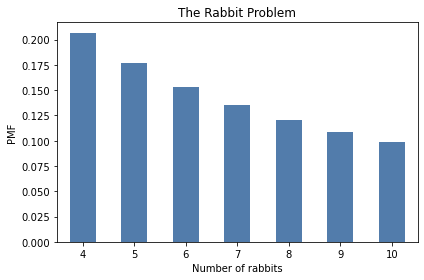

In [32]:
posterior = prior * likelihood
posterior.normalize()

posterior.bar(alpha=0.7)
decorate(xlabel='Number of rabbits',
         ylabel='PMF',
         title='The Rabbit Problem')

In [33]:
posterior.mean()

6.509929813748172